In [1]:
# Imports



# Função alternativa para ler arquivos FZ do disco (descomente conforme necessário)
# def load_from_fz(file_path):
#     tree = parse(file_path)
#     root = tree.getroot()
#     # Restante do código para ler o arquivo FZ

# Função alternativa para ler arquivos SVG do disco (descomente conforme necessário)
# def load_from_svg(file_path):
#     tree = parse(file_path)
#     root = tree.getroot()
#     # Restante do código para ler o arquivo SVG

# Imports
from xml.etree.ElementTree import ElementTree, fromstring
from random import randint
from xml.etree.ElementTree import ElementTree, fromstring, parse
from random import randint

import re
from xml.etree.ElementTree import ElementTree, fromstring
from random import randint

# Função para carregar informações dos componentes e conexões do XML
def load_from_xml(xml_string):
    tree = ElementTree(element=fromstring(xml_string))
    root = tree.getroot()
    nodes = []
    connections = []
    connector_mapping = {}
    for instance in root.findall('.//instances/instance'):
        instance_module_id = instance.get('moduleIdRef')
        instance_id = instance_module_id  # Use o ID do módulo completo
        if instance.get('id'):
            instance_id += '_' + instance.get('id')
        nodes.append(instance_id)
        for connector in instance.findall('.//connector'):
            full_connector_id = instance_id + '_' + connector.get('id')
            connector_mapping[full_connector_id] = instance_id
    for instance in root.findall('.//instances/instance'):
        instance_id = instance.get('moduleIdRef')
        if instance.get('id'):
            instance_id += '_' + instance.get('id')
        for connector in instance.findall('.//connector'):
            connected_to = connector.get('connectedTo')
            if connected_to:
                connected_instance_id = connector_mapping.get(connected_to)
                if connected_instance_id:
                    connections.append((instance_id, connected_instance_id))
    return {'nodes': nodes, 'connections': connections}



# Outras funções permanecem inalteradas...

def generate_chromosome(components_info, svg_info, board_dimensions, min_distance):
    chromosome = {'components': [], 'connections': []}
    for component_id in components_info['nodes']:
        width, height = svg_info[component_id]['dimensions']
        terminals = svg_info[component_id]['terminals'] # Pegamos os terminais do svg_info
        x = randint(0, board_dimensions[0] - width - min_distance)
        y = randint(0, board_dimensions[1] - height - min_distance)
        component = {'id': component_id, 'position': (x, y), 'dimensions': (width, height), 'terminals': terminals} 
        chromosome['components'].append(component)
    for connection in components_info['connections']:
        from_component_id, to_component_id = connection
        from_component = next(comp for comp in chromosome['components'] if comp['id'] == from_component_id)
        to_component = next(comp for comp in chromosome['components'] if comp['id'] == to_component_id)
        chromosome_connection = {'from': from_component, 'to': to_component}
        chromosome['connections'].append(chromosome_connection)
    return chromosome




# Restante do código...


# Função para gerar a população de cromossomos
def generate_population(components_info, svg_info, board_dimensions, min_distance, population_size):
    population = []
    for _ in range(population_size):
        chromosome = generate_chromosome(components_info, svg_info, board_dimensions, min_distance)
        population.append(chromosome)
    return population

# Função para verificar as conexões dos cromossomos
def check_connections(chromosome, components_info):
    expected_connections = components_info['connections']
    chromosome_connections = [(conn['from']['id'], conn['to']['id']) for conn in chromosome['connections']]
    return set(expected_connections) == set(chromosome_connections)

# Representação SVG dos componentes
svg_info = {
    'germanium_diode': {'dimensions': (5, 2), 'terminals': [(0, 1), (5, 1)]},
    'variable_capacitor': {'dimensions': (5, 5), 'terminals': [(0, 2.5), (5, 2.5)]},
    'resistor_resistor1': {'dimensions': (10, 2), 'terminals': [(0, 1), (10, 1)]},
    'resistor_resistor2': {'dimensions': (10, 2), 'terminals': [(0, 1), (10, 1)]},
    'transistor': {'dimensions': (5, 5), 'terminals': [(0, 1.5), (2.5, 5), (5, 1.5)]},
    'speaker': {'dimensions': (10, 10), 'terminals': [(5, 5)]}
}


# XML do circuito do rádio de germânio (substitua pelo XML real)
germanium_radio_xml = """
<module fritzingVersion="0.9.3b" moduleId="germaniumRadio" referenceFile="germaniumRadio.fzp">
  <instances>
    <instance moduleIdRef="germanium_diode">
      <connector id="connector0" connectedTo="variable_capacitor_connector0" />
    </instance>
    <instance moduleIdRef="variable_capacitor">
      <connector id="connector0" connectedTo="resistor1_connector0" />
    </instance>
    <instance moduleIdRef="resistor" id="resistor1">
      <connector id="connector0" connectedTo="resistor2_connector0" />
    </instance>
    <instance moduleIdRef="resistor" id="resistor2">
      <connector id="connector0" connectedTo="transistor_connector0" />
    </instance>
    <instance moduleIdRef="transistor">
      <connector id="connector0" connectedTo="speaker_connector0" />
    </instance>
    <instance moduleIdRef="speaker">
      <connector id="connector0" connectedTo="germanium_diode_connector0" />
    </instance>
  </instances>
</module>
"""

# Configurações
board_dimensions = (100, 100)
min_distance = 5
population_size = 10

# Carregando os componentes e conexões do XML
germanium_radio_components_info = load_from_xml(germanium_radio_xml)
print(germanium_radio_components_info['nodes'])

# Gerando uma população de cromossomos de exemplo

example_population_with_svg = generate_population(germanium_radio_components_info, svg_info, board_dimensions, min_distance, population_size)

# Testando as conexões do primeiro cromossomo da população
for i in range(population_size):
    connections_test_result = check_connections(example_population_with_svg[i], germanium_radio_components_info)
    print(connections_test_result)  # Deve imprimir True



['germanium_diode', 'variable_capacitor', 'resistor_resistor1', 'resistor_resistor2', 'transistor', 'speaker']
True
True
True
True
True
True
True
True
True
True


In [2]:
from math import sqrt

def orientation(p, q, r):
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0:
        return 0
    return 1 if val > 0 else -1

def on_segment(p, q, r):
    if q[0] <= max(p[0], r[0]) and q[0] >= min(p[0], r[0]) and \
       q[1] <= max(p[1], r[1]) and q[1] >= min(p[1], r[1]):
        return True
    return False

def do_intersect(p1, q1, p2, q2):
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if (o1 != o2 and o3 != o4) or \
       (o1 == 0 and on_segment(p1, p2, q1)) or \
       (o2 == 0 and on_segment(p1, q2, q1)) or \
       (o3 == 0 and on_segment(p2, p1, q2)) or \
       (o4 == 0 and on_segment(p2, q1, q2)):
        return True

    return False

def calculate_distance_to_line(point, line_start, line_end):
    x0, y0 = point
    x1, y1 = line_start
    x2, y2 = line_end
    return abs((x2 - x1) * (y0 - y1) - (x0 - x1) * (y2 - y1)) / sqrt((x2 - x1)**2 + (y2 - y1)**2)





def count_intersections(connections):
    intersections = 0
    for i in range(len(connections)):
        for j in range(i + 1, len(connections)):
            if do_intersect(connections[i]['from']['position'], connections[i]['to']['position'],
                            connections[j]['from']['position'], connections[j]['to']['position']):
                intersections += 1
    return intersections



def calculate_total_distance(connections):
    total_distance = 0
    for connection in connections:
        x1, y1 = connection['from']['position']
        x2, y2 = connection['to']['position']
        distance = sqrt((x2 - x1)**2 + (y2 - y1)**2)
        total_distance += distance
    return total_distance


def check_min_distance(components, connections, min_distance=5):
    violations = 0
    for component in components:
        terminals = component['terminals']
        for terminal in terminals:
            terminal_position = (component['position'][0] + terminal[0], component['position'][1] + terminal[1])
            for connection in connections:
                distance = calculate_distance_to_line(terminal_position, connection['from']['position'], connection['to']['position'])
                if distance < min_distance:
                    violations += 1
    return violations


def fitness_function(chromosome):
    # Calcula o número de interseções entre os caminhos
    intersections = 0
    path_keys = list(chromosome.paths.keys())
    for i in range(len(path_keys)):
        for j in range(i + 1, len(path_keys)):
            path1 = chromosome.paths[path_keys[i]]
            path2 = chromosome.paths[path_keys[j]]
            for k in range(len(path1) - 1):
                for l in range(len(path2) - 1):
                    if do_intersect(path1[k], path1[k+1], path2[l], path2[l+1]):
                        intersections += 1
    
    # Calcula a distância total dos caminhos
    total_distance = 0
    for path in chromosome.paths.values():
        for i in range(len(path) - 1):
            x1, y1 = path[i]
            x2, y2 = path[i+1]
            distance = sqrt((x2 - x1)**2 + (y2 - y1)**2)
            total_distance += distance
    
    # Calcula violações de distância mínima (essa parte está sujeita a como você definir os terminais nos resistores)
    min_distance_violations = 0
    for resistor in chromosome.resistors:
        for path in chromosome.paths.values():
            for point in path:
                distance = calculate_distance_to_line(point, resistor.terminal1.position, resistor.terminal2.position)
                if distance < 5:  # Distância mínima que você quer manter
                    min_distance_violations += 1
    
    # Calcula o valor da aptidão
    fitness = -intersections * 10 - total_distance - min_distance_violations * 20
    
    return fitness, total_distance, intersections, min_distance_violations



def fitness_function2(chromosome):
    # Avalia o número de interseções de trilhas
    intersections = count_intersections(chromosome['connections'])
    
    # Avalia a distância total das trilhas
    total_distance = calculate_total_distance(chromosome['connections'])
    
    # Avalia a distância mínima entre componentes e trilhas
    min_distance_violations = check_min_distance(chromosome['components'], chromosome['connections'])
    
    # Calcula a aptidão
    fitness = -intersections * 10 - total_distance - min_distance_violations * 20
    
    return fitness, total_distance, intersections, min_distance_violations



In [3]:







        

    
    

from math import sqrt

def orientation(p, q, r):
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0:
        return 0
    return 1 if val > 0 else -1

def on_segment(p, q, r):
    if q[0] <= max(p[0], r[0]) and q[0] >= min(p[0], r[0]) and \
       q[1] <= max(p[1], r[1]) and q[1] >= min(p[1], r[1]):
        return True
    return False

def do_intersect(p1, q1, p2, q2):
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if (o1 != o2 and o3 != o4) or \
       (o1 == 0 and on_segment(p1, p2, q1)) or \
       (o2 == 0 and on_segment(p1, q2, q1)) or \
       (o3 == 0 and on_segment(p2, p1, q2)) or \
       (o4 == 0 and on_segment(p2, q1, q2)):
        return True

    return False
       

def count_intersections(paths):
    intersections = 0
    path_keys = list(paths.keys())
    for i in range(len(path_keys)):
        for j in range(i + 1, len(path_keys)):
            path1 = paths[path_keys[i]]
            path2 = paths[path_keys[j]]
            for k in range(len(path1) - 1):
                for l in range(len(path2) - 1):
                    if do_intersect(path1[k], path1[k+1], path2[l], path2[l+1]):
                        intersections += 1
    return intersections

def calculate_total_distance(paths):
    total_distance = 0
    for path in paths.values():
        for i in range(len(path) - 1):
            x1, y1 = path[i]
            x2, y2 = path[i + 1]
            distance = sqrt((x2 - x1)**2 + (y2 - y1)**2)
            total_distance += distance
    return total_distance

def check_min_distance(resistors, paths, min_distance=5):
    violations = 0
    for resistor in resistors:
        for path in paths.values():
            for point in path:
                distance = calculate_distance_to_line(point, resistor.terminal1.position, resistor.terminal2.position)
                if distance < min_distance:
                    violations += 1
    return violations
       
def fitness_function(chromosome):
    intersections = count_intersections(chromosome.paths)
    total_distance = calculate_total_distance(chromosome.paths)
    min_distance_violations = check_min_distance(chromosome.resistors, chromosome.paths)
    
    fitness = -intersections * 10 - total_distance - min_distance_violations * 20
    return fitness, total_distance, intersections, min_distance_violations
        
        

afast_trilhas = 0
[(20, 43), (21, 43), (22, 43), (23, 43), (24, 43), (25, 43), (26, 43), (27, 43), (28, 43), (29, 43), (30, 43), (31, 43), (32, 43), (33, 43), (34, 43), (35, 43), (36, 43), (36, 42), (36, 41), (36, 40), (36, 39), (36, 38), (36, 37), (36, 36), (36, 35), (36, 34), (36, 33), (36, 32), (36, 31), (36, 30), (36, 29), (36, 28), (36, 27), (36, 26), (37, 26), (38, 26), (39, 26), (40, 26)]

afast_trilhas = 0
[(56, 60), (56, 61), (56, 62), (56, 63), (56, 64), (56, 65), (56, 66), (56, 67), (56, 68), (56, 69), (56, 70), (56, 71), (56, 72), (56, 73), (56, 74), (56, 75), (56, 76), (56, 77), (56, 78), (56, 79), (56, 80)]

afast_trilhas = 0
[(63, 60), (63, 61), (63, 62), (63, 63), (63, 64), (63, 65), (63, 66), (63, 67), (63, 68), (63, 69), (63, 70), (63, 71), (63, 72), (63, 73), (63, 74), (63, 75), (63, 76), (63, 77), (63, 78), (63, 79), (63, 80)]

afast_trilhas = 0
[(56, 60), (55, 60), (54, 60), (54, 61), (54, 62), (54, 63), (54, 64), (54, 65), (54, 66), (54, 67), (54, 68), (54, 69), (

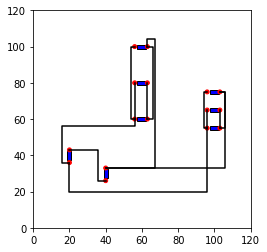

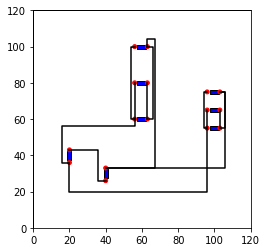

SVG StringBB:
<?xml version="1.0" ?>
<svg xmlns="http://www.w3.org/2000/svg" version="1.1" id="breadboard">
  <g id="resistor1" moduleIdRef="resistor">
    <rect x="17.5" y="38.91" width="5" height="2.18" style="fill:blue;stroke:black;"/>
  </g>
  <g id="resistor2" moduleIdRef="resistor">
    <rect x="37.5" y="28.91" width="5" height="2.18" style="fill:blue;stroke:black;"/>
  </g>
  <g id="resistor3" moduleIdRef="resistor">
    <rect x="57.5" y="58.91" width="5" height="2.18" style="fill:blue;stroke:black;"/>
  </g>
  <g id="resistor4" moduleIdRef="resistor">
    <rect x="57.5" y="78.91" width="5" height="2.18" style="fill:blue;stroke:black;"/>
  </g>
  <g id="resistor5" moduleIdRef="resistor">
    <rect x="57.5" y="98.91" width="5" height="2.18" style="fill:blue;stroke:black;"/>
  </g>
  <g id="resistor6" moduleIdRef="resistor">
    <rect x="97.5" y="53.91" width="5" height="2.18" style="fill:blue;stroke:black;"/>
  </g>
  <g id="resistor7" moduleIdRef="resistor">
    <rect x="97.5" y

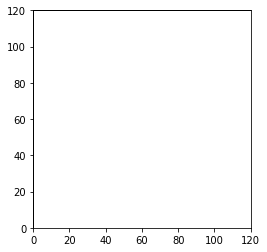

In [4]:





# Importing the necessary libraries again
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
from xml.etree.ElementTree import Element, SubElement, ElementTree
from xml.dom import minidom
import xml.etree.ElementTree as ET




class Resistor:
    def __init__(self, moduleIdRef, id, position, angle=0, width=5, height=2.18, terminal_distance1=1,terminal_distance2=1, hole_diameter=2.18):
    #def __init__(self, moduleIdRef, id, position, angle=0, width=10, height=5, terminal_distance1=3,terminal_distance2=3, hole_diameter=2):
    
        self.moduleIdRef = moduleIdRef
        self.id = id
        self.width = width
        self.height = height
        self.terminal_distance1= terminal_distance1
        self.terminal_distance2= terminal_distance2
        self.hole_diameter = hole_diameter
        self.position = position
        self.angle = angle
        self.terminal1, self.terminal2 = self.get_terminal_positions()
        
        self.terminal1_id = f"terminal1" #f"{self.id}_terminal1"
        self.terminal2_id = f"terminal2" #f"{self.id}_terminal2"

    def draw(self, ax):
        x, y = self.position
        # Rotating the resistor
        t = plt.gca().transData
        t_rotate = mpl.transforms.Affine2D().rotate_deg_around(x, y, self.angle) + t
        # Drawing the rectangle of the resistor
        resistor = patches.Rectangle((x - self.width/2, y - self.height/2), self.width, self.height, linewidth=1, edgecolor='black', facecolor='blue', transform=t_rotate)
        ax.add_patch(resistor)
        # Drawing the holes of the terminals
        '''
        for sign in [-1, 1]:
            terminal_x = x - sign * (self.width/2 + self.terminal_distance)
            terminal = plt.Circle((terminal_x, y), self.hole_diameter/2, color='red', transform=t_rotate)
            ax.add_artist(terminal)
        '''
        terminal1 = (int(x - (self.width/2 + self.terminal_distance1)), y)
        terminal = plt.Circle(terminal1, self.hole_diameter/2, color='red', transform=t_rotate)
        ax.add_artist(terminal)
        terminal2 = (int(x+ (self.width/2 + self.terminal_distance2)), y)
        terminal = plt.Circle(terminal2, self.hole_diameter/2, color='red', transform=t_rotate)
        ax.add_artist(terminal)
        
    def get_terminal_positions(self):
        x, y = self.position
        if self.angle == 0:
            terminal1 = (int(x - (self.width/2 + self.terminal_distance1)), y)
            terminal2 = (int(x + (self.width/2 + self.terminal_distance2)), y)
        elif self.angle==90:
            terminal2 = (x, int(y + (self.width/2 + self.terminal_distance2)))
            terminal1 = (x, int(y - (self.width/2 + self.terminal_distance1)))  
            #print(terminal1)
            #print(terminal2)
        return terminal1, terminal2
    def find_terminal_id(self, terminal):
        if terminal == self.terminal1:
            return self.terminal1_id 
         

        elif terminal == self.terminal2:
            return self.terminal2_id

    def to_svg_element(self):
        x, y = self.position
        elem = ET.Element(
            'g',  # Grupo SVG para agrupar todos os elementos associados a este resistor
            {
                'id': self.id,
                'moduleIdRef': self.moduleIdRef
            }
        )
        
        rect = ET.SubElement(
            elem,
            'rect',
            {
                'x': str(x - self.width/2), 
                'y': str(y - self.height/2), 
                'width': str(self.width), 
                'height': str(self.height),
                'style': 'fill:blue;stroke:black;'
            }
        )
        
        return elem
    

    def to_svg_elementPCB(self, hole_diameter=2, track_width=1):
        elem = ET.Element(
            'g',
            {
                'id': self.id,
            }
        )

        terminal1_circle = ET.SubElement(
            elem, 'circle',
            {
                'cx': str(self.terminal1[0]),
                'cy': str(self.terminal1[1]),
                'r': str(hole_diameter / 2),
                'style': 'fill:none;stroke:black;'
            }
        )

        terminal2_circle = ET.SubElement(
            elem, 'circle',
            {
                'cx': str(self.terminal2[0]),
                'cy': str(self.terminal2[1]),
                'r': str(hole_diameter / 2),
                'style': 'fill:none;stroke:black;'
            }
        )

        track = ET.SubElement(
            elem, 'path',
            {
                'd': f"M {self.terminal1[0]} {self.terminal1[1]} L {self.terminal2[0]} {self.terminal2[1]}",
                'style': f'stroke:black;stroke-width:{track_width};'
            }
        )
    
        return elem

        
        

class Cromossomo:
    def __init__(self):
        self.resistors = []  # Lista de resistores
        self.paths = {}  # Dicionário para armazenar os caminhos entre terminais
        self.conexoes = {}  # atributo para armazenar as conexões entre terminais dos resistores
        


    def add_resistor(self, resistor):
        self.resistors.append(resistor)
        
    def add_path(self, terminal1, terminal2, path):
        self.paths[(terminal1, terminal2)] = path
        
        
    def add_conexao(self, resistor_origem, terminal_origem, resistor_destino, terminal_destino):
        chave = f"{resistor_origem}_{terminal_origem}"
        
        # Verificando se a conexão inversa já existe
        chave_inversa = f"{resistor_destino}_{terminal_destino}"
        if chave_inversa in self.conexoes and f"{resistor_origem}_{terminal_origem}" in self.conexoes[chave_inversa]:
            return

        if chave not in self.conexoes:
            self.conexoes[chave] = []
        
        self.conexoes[chave].append(f"{resistor_destino}_{terminal_destino}")
        
    def draw_chromosome(self, board_width, board_height):
        fig, ax = plt.subplots()
    
        # Desenhar a placa como um retângulo
        board = patches.Rectangle((0, 0), board_width, board_height, linewidth=1, edgecolor='black', facecolor='none')
        ax.add_patch(board)
    
        # Desenhar cada resistor
        for resistor in self.resistors:
            if resistor is not None:
                resistor.draw(ax)
    
        # Desenhar cada conexão
        for path in self.paths.values():
            xs, ys = zip(*path)
            ax.plot(xs, ys, color="black")
    
        ax.set_xlim(0, board_width)
        ax.set_ylim(0, board_height)
        ax.set_aspect('equal', 'box')
        plt.show()
    
    def if_inverse_conexao_exist(self, resistor_origem, terminal_origem, resistor_destino, terminal_destino):
        chave_inversa = f"{resistor_origem}_{terminal_origem}"
        chave = f"{resistor_destino}_{terminal_destino}"
        return chave_inversa in self.conexoes and chave in self.conexoes[chave_inversa]
    def resistor_already_registered(self, new_resistor):
        for existing_resistor in self.resistors:
            if existing_resistor.id == new_resistor.id:
                return True
        return False
    
    def generate_fritzing_breadboard_svg(self, file_name):
        
        root = ET.Element('svg', {'xmlns': 'http://www.w3.org/2000/svg', 'version': '1.1', 'id': 'breadboard'})
        for resistor in self.resistors:
            root.append(resistor.to_svg_element())
        
        tree = ET.ElementTree(root)
        tree.write(file_name + "_breadboard.svg")

        svg_string = minidom.parseString(ET.tostring(root)).toprettyxml(indent="  ")
        return  svg_string

    def generate_fritzing_breadboard_xml(self, file_name):
        root = ET.Element('module', {
            'fritzingVersion': '0.9.3b',
            'moduleId': 'customModule',
        'referenceFile': f'{file_name}.fzp'
        })

        instances = ET.SubElement(root, 'instances')
    
        for resistor in self.resistors:
            instance = ET.SubElement(instances, 'instance', {'moduleIdRef': resistor.moduleIdRef, 'id': resistor.id})
        
            for key, values in self.conexoes.items():
                if key.startswith(resistor.id):
                    for value in values:
                        connector = ET.SubElement(instance, 'connector', {'id': key.split('_')[1]})
                        connector.set('connectedTo', value)
                    
        tree = ET.ElementTree(root)
        tree.write(f"{file_name}_breadboard.fzz")

        xml_string = minidom.parseString(ET.tostring(root)).toprettyxml(indent="  ")
        return xml_string

    
    def generate_fritzing_pcb_svg(self, file_name):
        root = ET.Element('svg', {'xmlns': 'http://www.w3.org/2000/svg', 'version': '1.1', 'id': 'pcb'})
        
        for resistor in self.resistors:
            root.append(resistor.to_svg_elementPCB())
        
        for path in self.paths.values():
            path_elem = ET.SubElement(root, 'path', {'id': 'track'})
            path_str = ' '.join([f"M {x} {y}" for x, y in path])
            path_elem.set('d', path_str)
            path_elem.set('style', 'stroke:black;stroke-width:1;')
        
        tree = ET.ElementTree(root)
        tree.write(file_name + "_pcb.svg")

        svg_string = minidom.parseString(ET.tostring(root)).toprettyxml(indent="  ")
        return svg_string
    def generate_fritzing_pcb_xml(self, file_name):
        root = ET.Element('module', {
            'fritzingVersion': '0.9.3b',
            'moduleId': 'customModule',
            'referenceFile': f'{file_name}.fzp'
        })

        instances = ET.SubElement(root, 'instances')

        for resistor in self.resistors:
            instance = ET.SubElement(instances, 'instance', {'moduleIdRef': resistor.moduleIdRef, 'id': resistor.id})
    
            for key, values in self.conexoes.items():
                if key.startswith(resistor.id):
                    for value in values:
                        connector = ET.SubElement(instance, 'connector', {'id': key.split('_')[1]})
                        connector.set('connectedTo', value)

        # Adicionando informação do caminho (path) para as conexões
        pcb = ET.SubElement(root, 'pcb')
        for (terminal1, terminal2), path in self.paths.items():
            wire = ET.SubElement(pcb, 'wire')
            wire.set('from', terminal1)
            wire.set('to', terminal2)
            wire.set('points', ','.join([f"{x},{y}" for x, y in path]))
        
        tree = ET.ElementTree(root)
        tree.write(f"{file_name}_pcb.fzz")

        xml_string = minidom.parseString(ET.tostring(root)).toprettyxml(indent="  ")
        return xml_string    
    
from xml.etree import ElementTree as ET

def gera_cromossomoStrings(svg_str, xml_str):
    # Inicializa um novo cromossomo
    cromo = Cromossomo()
    
    # Analisa a string SVG
    root_svg = ET.fromstring(svg_str)
    for elem in root_svg.findall(".//g"):
        id = elem.get('id')
        print(id)
        rect_elem = elem.find('.//rect')
        if rect_elem is not None:
            
            x, y = float(rect_elem.get('x')), float(rect_elem.get('y'))
            width, height = float(rect_elem.get('width')), float(rect_elem.get('height'))
            res = Resistor(moduleIdRef="Module", id=id, width=width, height=height, terminal_distance=1, hole_diameter=1, position=(x,y))
            cromo.add_resistor(res)
        path_elem = elem.find('.//path')
        if path_elem is not None:
            d = path_elem.get('d')
            cromo.add_path(d)

    # Analisa a string XML
    root_xml = ET.fromstring(xml_str)
    for elem in root_xml.findall(".//instance"):
        id = elem.get('id')
        moduleIdRef = elem.get('moduleIdRef')
        for connector in elem.findall('.//connector'):
            terminal = connector.get('id')
            connectedTo = connector.get('connectedTo')
            if connectedTo:
                res_dest_id, terminal_dest = connectedTo.split("_")
                cromo.add_conexao(id, terminal, res_dest_id, terminal_dest)
    
    return cromo

def gera_cromossomoFile(svg_file, xml_file):
    # Carrega os conteúdos dos arquivos
    with open(svg_file, 'r') as f:
        svg_str = f.read()
    with open(xml_file, 'r') as f:
        xml_str = f.read()
    
    return gera_cromossomoStrings(svg_str, xml_str)

    
    
def find_resistor_by_terminal(target_terminal, resistors):
    for resistor in resistors:
        terminal1, terminal2 = resistor.get_terminal_positions()
        if target_terminal == terminal1 or target_terminal == terminal2:
            return resistor
    return None


def create_board(terminal1, terminal2, resistors, used_cells, width, height,allow_crossing=False, MIN_DISTANCE=2):
    print(f"afast_trilhas = {AFast_Trilhas}" )
    board = np.zeros((height, width))
    global f  # Declara 'f' como global

    
    # Convertendo 'used_cells' para uma lista se for um conjunto
    if isinstance(used_cells, set):
        used_cells = list(used_cells)
    # O loop externo itera sobre cada sublista de used_cells (cada caminho)
    if not allow_crossing:
        for path in used_cells:
        # O loop interno faz o que você já estava fazendo, mas apenas para este caminho
        
            for i in range(len(path) - 1):
                x1, y1 = map(int, path[i])
                x2, y2 = map(int, path[i + 1])

                if y1 == y2:  # Se a linha é horizontal
                    y_min = min(y1 - AFast_Trilhas, y1 + AFast_Trilhas)
                    y_max = max(y1 - AFast_Trilhas, y1 + AFast_Trilhas)
                    x_min = min(x1, x2)
                    x_max = max(x1, x2)
                    board[y_min:y_max+1, x_min:x_max+1] = -1

                elif x1 == x2:  # Se a linha é vertical
                    y_min = min(y1, y2)
                    y_max = max(y1, y2)
                    x_min = min(x1 - AFast_Trilhas, x1 + AFast_Trilhas)
                    x_max = max(x1 - AFast_Trilhas, x1 + AFast_Trilhas)
                    board[y_min:y_max+1, x_min:x_max+1] = -1
    
    # Desabilitando células com base na orientação dos segmentos. esses segmentos pertence a conexões entre terminais
    '''
    for i in range(len(used_cells) - 1):
        x1, y1 = map(int, used_cells[i])
        x2, y2 = map(int, used_cells[i + 1])
        
    
        if y1 == y2:  # Se a linha é horizontal
            y_min = y1 - AFast_Trilhas
            y_max = y1 + AFast_Trilhas
            x_min = x1
            x_max = x2
            
            board[y_min:y_max+1, x_min:x_max+1] = -1

        elif x1 == x2:  # Se a linha é vertical
            print("x1=x2")
            print(x1,y1)
            print(x2,y2)

            y_min = y1
            y_max = y2
            x_min = x1 - AFast_Trilhas
            x_max = x1 + AFast_Trilhas
            
        
            board[y_min:y_max+1, x_min:x_max+1] = -1
    '''
    
   
            
    special_resistors = []
    for resistor in resistors:
        x, y = map(int, resistor.position)
        w = (resistor.width +resistor.terminal_distance1+resistor.terminal_distance2 + 2 * MIN_DISTANCE) // 2
        h = (resistor.height + 2 * MIN_DISTANCE) // 2
        if resistor.angle==0:
            x_min, x_max = int(max(0, x - w)), int(min(width, x + w))
            y_min, y_max = int(max(0, y - h)), int(min(height, y + h))
        if resistor.angle==90:
            x_min, x_max = int(max(0, x - h)), int(min(width, x + h))
            y_min, y_max = int(max(0, y - w)), int(min(height, y + w))

        #resistores especiais sao aqueles que devem ser totalmente desabilitados
        is_special = any(terminal in resistor.get_terminal_positions() for terminal in [terminal1, terminal2])
        if is_special:
            
            special_resistors.append(resistor)
        
        if resistor not in special_resistors:
            
            board[y_min:y_max+1, x_min:x_max+1] = -1
        
        # Resto do código
        if resistor in special_resistors:
            
            term1, term2 = resistor.get_terminal_positions()
            board[y_min:y_max+1, x_min:x_max+1] = -1
            
            
            # Habilitar os terminais de entrada e saída
            if term1 == terminal1 or term1 == terminal2:
                board[int(term1[1]), int(term1[0])] = 0
                if resistor.angle == 0:
                    board[y, int(x_min):int(term1[0])+1] = 0
                    board[int(y_min):int(y_max)+1,int(term1[0])] = 0
                elif resistor.angle == 90:
                    board[int(y_min):int(term1[1]+1), x] = 0
                    board[int(term1[1]), int(x_min):int(x_max)+1] = 0
            if term2 == terminal1 or term2 == terminal2:
                board[int(term2[1]), int(term2[0])] = 0
                if resistor.angle == 0:
                    board[y, int(term2[0]):int(x_max)+1] = 0
                    board[int(y_min):int(y_max)+1, int(term2[0])] = 0
                elif resistor.angle == 90:
                    board[int(term2[1]):int(y_max)+1, x] = 0
                    board[int(term2[1]), int(x_min):int(x_max)+1] = 0
    '''
    for i in range(len(used_cells) - 1):
        x1, y1 = map(int, used_cells[i])
        x2, y2 = map(int, used_cells[i + 1])

        if y1 == y2:  # Se a linha é horizontal
            y_min = min(y1 - AFast_Trilhas, y1 + AFast_Trilhas)
            y_max = max(y1 - AFast_Trilhas, y1 + AFast_Trilhas)
            x_min = min(x1, x2)
            x_max = max(x1, x2)

            board[y_min:y_max+1, x_min:x_max+1] = -1

        elif x1 == x2:  # Se a linha é vertical
            y_min = min(y1, y2)
            y_max = max(y1, y2)
            x_min = min(x1 - AFast_Trilhas, x1 + AFast_Trilhas)
            x_max = max(x1 - AFast_Trilhas, x1 + AFast_Trilhas)

            board[y_min:y_max+1, x_min:x_max+1] = -1                
   '''
   
 
    f.write(f'Estado para terminais {terminal1} e {terminal2}:\n')
    for i in reversed(range(height)):
        row_str = ''
        for j in range(width):
            if board[i, j] == -1:
                row_str += 'X'
            else:
                row_str += '-'
        f.write(row_str + '\n')

    
    
    
    return board
    '''
    #if terminal1==(28.0, 20) and terminal2==(32.0, 40): 
    if True:
    #if terminal1==(48.0, 30) and terminal2==(108.0, 75): 
        for i in range(0,height-1):
            row_str = ""
            for j in range(0,width-1):
                if board[i,j] == 0:
                    row_str += "\033[30m0\033[0m"
                elif board[i,j] == -1:
                    row_str += "\033[31m0\033[0m"
            print(row_str) 
      
        for row in board:
            row_str = ""
            for cell in row:
                if cell == 0:
                    row_str += "\033[30m0\033[0m"
                elif cell == -1:
                    row_str += "\033[31m0\033[0m"
            print(row_str)
        '''







# O resto do código permanece o mesmo

    

    # Restante do código é o mesmo
    ...



def heuristic2(current, goal):
    # Distância Euclidiana entre os pontos atual e objetivo
    return np.sqrt((current[0] - goal[0]) ** 2 + (current[1] - goal[1]) ** 2)
def heuristic(current, goal):
    return abs(current[0] - goal[0]) + abs(current[1] - goal[1])
# Cost function with turns count

def astar(start, goal, board):
    open_list = [start]
    closed_list = set()
    g_score = {start: 0}
    turns_count = {start: 0}  # New turns_count dictionary
    came_from = {start: None}
    
    while len(open_list) > 0:
        current = min(open_list, key=lambda x: g_score[x] + heuristic(x, goal))
        if current == goal:
            path = []
            while current is not None:
                path.insert(0, current)
                current = came_from[current]
            final_cost = g_score[goal]
            final_turns = turns_count[goal]
            f.write("Final cost:" + str(final_cost)+ '\n')
            f.write("Final turns:" + str(final_turns)+ '\n')

            
            f.write(str(path)+ '\n')
            # Dentro de draw_contour_connection ou onde você invoca A*
           

            
            return path

        open_list.remove(current)
        closed_list.add(current)
        
        neighbors = [(current[0] + dx, current[1] + dy) for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]]
        for neighbor in neighbors:
            x, y = map(int, neighbor)
            
            if x < 0 or x >= board.shape[1] or y < 0 or y >= board.shape[0] or neighbor in closed_list or board[y][x] == -1:
                #continue
            
            #if x < 0 or x >= board.shape[1] or y < 0   or y >= board.shape[0] or neighbor in closed_list or board[board.shape[0] - 1 - y, x] == -1:
                continue
            # Count turns
            if came_from[current]:
                delta1 = (current[0] - came_from[current][0], current[1] - came_from[current][1])
                delta2 = (neighbor[0] - current[0], neighbor[1] - current[1])
                turns = turns_count[current] + (1 if delta1 != delta2 else 0)
            else:
                turns = 0

            tentative_g_score = g_score[current] + heuristic(current, neighbor) + penalty* turns  # Adding penalty for turns
            if neighbor not in open_list or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                turns_count[neighbor] = turns  # Update the turns count
                if neighbor not in open_list:
                    open_list.append(neighbor)
    return []





def draw_contour_connection(ax, terminal1, terminal2, resistors, used_cells, MIN_DISTANCE=2, hole_diameter=2):

    special_resistors = []
    terminal_positions = set()

    

    # Desenhe furos nos terminais que não pertencem a um resistor
    for resistor in resistors:
        terminal_positions.update(resistor.get_terminal_positions())
        
    for terminal in [terminal1, terminal2]:
        if terminal not in terminal_positions:
            circle = plt.Circle(terminal, hole_diameter / 2, color='red')
            ax.add_artist(circle)

    # Ajustar os terminais para os pontos de entrada permitidos
    x1, y1 = terminal1
    x2, y2 = terminal2

    width, height = 120, 120
    board = create_board(terminal1, terminal2,resistors,used_cells,  width, height, False,MIN_DISTANCE)
    #print(f'terminal1:{terminal1}')
    #print(f'terminal2:{terminal2}')
    
    # Execute o algoritmo A* para encontrar o caminho
    resistor1 = find_resistor_by_terminal(terminal1, resistors)
    resistor2 = find_resistor_by_terminal(terminal2, resistors)

    if resistor1:
        if not cromossomo.resistor_already_registered(resistor1):
            cromossomo.add_resistor(resistor1)
    if resistor2:
        if not cromossomo.resistor_already_registered(resistor2):
            cromossomo.add_resistor(resistor2)

    path = astar((x1, y1), (x2, y2), board)
    if len(path) == 0:
        board = create_board(terminal1, terminal2, resistors, used_cells, width, height, True,MIN_DISTANCE)
        path = astar((x1, y1), (x2, y2), board)
    print(path)
    used_cells.append(path)  # Atualizando as células usadas
    cromossomo.add_path(terminal1, terminal2, path)
    # Adicionar a conexão
    terminal_id1 = resistor1.find_terminal_id(terminal1)
    terminal_id2 = resistor2.find_terminal_id(terminal2)
    
    # Verifica se a conexão inversa já existe
    if not cromossomo.if_inverse_conexao_exist(resistor2.id, resistor2.terminal2_id, resistor1.id, resistor1.terminal1_id):
        cromossomo.add_conexao(resistor1.id, resistor1.terminal1_id, resistor2.id, resistor2.terminal2_id)

    print()
    # Desenhe a conexão usando o caminho
    if path:
        
        xs, ys = zip(*path)
        ax.plot(xs, ys, color="black")


        



class Group:
    def __init__(self, resistors, connection_type):
        self.resistors = resistors
        self.connection_type = connection_type

    def get_terminal_positions(self):
        if self.connection_type == "serie":
            return self.resistors[0].get_terminal_positions()[0], self.resistors[-1].get_terminal_positions()[1]
        elif self.connection_type == "paralelo":
            # Just return the terminals of the first and last resistor
            return self.resistors[0].get_terminal_positions()[0], self.resistors[-1].get_terminal_positions()[1]
    
    def draw(self, ax, all_resistors, used_cells):
        for resistor in self.resistors:
            resistor.draw(ax)
        if self.connection_type == "serie":
            
            for i in range(len(self.resistors) - 1):
                terminal1 = self.resistors[i].get_terminal_positions()[1]
                terminal2 = self.resistors[i + 1].get_terminal_positions()[0]
                
                draw_contour_connection(ax, terminal1, terminal2, all_resistors, used_cells)
        elif self.connection_type == "paralelo":
            terminals = [resistor.get_terminal_positions() for resistor in self.resistors]
            for i in range(1, len(terminals)):
                draw_contour_connection(ax, terminals[0][0], terminals[i][0], all_resistors, used_cells)
                draw_contour_connection(ax, terminals[0][1], terminals[i][1], all_resistors, used_cells)


        
    
    
    
    
    
    
    
    
    

    
    def draw2(self, ax,used_cells):
        for resistor in self.resistors:
            resistor.draw(ax)
        if self.connection_type == "serie":
            for i in range(len(self.resistors) - 1):
                terminal1 = self.resistors[i].get_terminal_positions()[1]
                terminal2 = self.resistors[i + 1].get_terminal_positions()[0]
                print(f'terminal1:{terminal1}')
                print(f'terminal2:{terminal2}')
                
                
                ax.plot([terminal1[0], terminal2[0]], [terminal1[1], terminal2[1]], color="black")
        elif self.connection_type == "paralelo":
            terminals = [resistor.get_terminal_positions() for resistor in self.resistors]
            for i in range(1, len(terminals)):
                
                
                ax.plot([terminals[0][0][0], terminals[i][0][0]], [terminals[0][0][1], terminals[i][0][1]], color="black")
                ax.plot([terminals[0][1][0], terminals[i][1][0]], [terminals[0][1][1], terminals[i][1][1]], color="black")


    # ... rest of the Group class remains the same ...
    


class Connection:
    
    
    def __init__(self, groups, connection_type="serie"):
        self.groups = groups
        self.connection_type = connection_type
    def update_cromossome(self, cromossomo, path):
        cromossomo.connections.append(path)
    
    
    
    
    
    def draw(self, ax, used_cells):
        all_resistors = [resistor for group in self.groups for resistor in group.resistors]
        for group in self.groups:
            group.draw(ax, all_resistors,used_cells)
        if self.connection_type == "serie":
            
            for i in range(len(self.groups) - 1):
                terminal1 = self.groups[i].get_terminal_positions()[1]
                terminal2 = self.groups[i + 1].get_terminal_positions()[0]
                
                draw_contour_connection(ax, terminal1, terminal2, all_resistors, used_cells)
        elif self.connection_type == "paralelo":
            group_terminals = [group.get_terminal_positions() for group in self.groups]
            for i in range(1, len(group_terminals)):
                draw_contour_connection(ax, group_terminals[0][0], group_terminals[i][0], all_resistors, used_cells)
                draw_contour_connection(ax, group_terminals[0][1], group_terminals[i][1], all_resistors, used_cells)    
    
    
   

    

    def draw2(self, ax,used_cells):
        for group in self.groups:
            group.draw(ax,used_cells)
        if self.connection_type == "serie":
            for i in range(len(self.groups) - 1):
                terminal1 = self.groups[i].get_terminal_positions()[1]
                terminal2 = self.groups[i + 1].get_terminal_positions()[0]
                print(terminal1)
                print(terminal2)
                ax.plot([terminal1[0], terminal2[0]], [terminal1[1], terminal2[1]], color="black")
        elif self.connection_type == "paralelo":
            # Connecting each group in parallel with the next
            for i in range(len(self.groups) - 1):
                terminals1 = self.groups[i].get_terminal_positions()
                terminals2 = self.groups[i + 1].get_terminal_positions()
                ax.plot([terminals1[0][0], terminals2[0][0]], [terminals1[0][1], terminals2[0][1]], color="black")
                ax.plot([terminals1[1][0], terminals2[1][0]], [terminals1[1][1], terminals2[1][1]], color="black")

AFast_Trilhas = 0  # Parâmetro para afastamento entre trilhas em mm
    
penalty=3
used_cells = []  # Conjunto de células usadas
#print(len(used_cells))

fig, ax = plt.subplots()


resistor1 = Resistor("resistor", "resistor1", (20, 40), 90)
resistor2 = Resistor("resistor", "resistor2", (40, 30), 90)
resistor3 = Resistor("resistor", "resistor3", (60, 60), 0)
resistor4 = Resistor("resistor", "resistor4", (60, 80), 0)
resistor5 = Resistor("resistor", "resistor5", (60, 100), 0)
resistor6 = Resistor("resistor", "resistor6", (100, 55), 0)
resistor7 = Resistor("resistor", "resistor7", (100, 65), 0)
resistor8 = Resistor("resistor", "resistor8", (100, 75), 0)


resistors = [resistor1, resistor2, resistor3, resistor4, resistor5, resistor6, resistor7, resistor8]

# Creating groups of resistors
serie_group = Group(resistors[:2], "serie")
paralelo_group = Group(resistors[2:5], "paralelo")
paralelo_group2 = Group(resistors[5:], "paralelo")

# Connecting groups
serieparalelo_connection = Connection([serie_group, paralelo_group,paralelo_group2], "paralelo")
serie_connection = Connection([serie_group], "serie")
# Drawing the connections
f = open('estado_do_board.txt', 'a')
# Antes de começar a desenhar a PCB
cromossomo = Cromossomo()

serieparalelo_connection.draw(ax,used_cells)
f.close()

plt.xlim(0, 120)
plt.ylim(0, 120)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

cromossomo.draw_chromosome(120,120)

svg_stringBB= cromossomo.generate_fritzing_breadboard_svg("resistor")
xml_stringBB = cromossomo.generate_fritzing_breadboard_xml("resistor")
svg_stringPCB= cromossomo.generate_fritzing_pcb_svg("resistor")
xml_stringPCB = cromossomo.generate_fritzing_pcb_xml("resistor")



print("SVG StringBB:")
print(svg_stringBB)

print("\nXML StringBB:")
print(xml_stringBB)


print("SVG StringPCB:")
print(svg_stringPCB)

print("\nXML StringPCB:")
print(xml_stringPCB)

cromo_teste = gera_cromossomoStrings(svg_stringPCB, xml_stringPCB)

# Depuração: Imprima ou inspecione os resultados
print("Resistores:", cromo_teste.resistors)
print("Caminhos:", cromo_teste.paths)
print("Conexões:", cromo_teste.conexoes)

# Desenhe o cromossomo
cromo_teste.draw_chromosome(120, 120)






In [44]:
chromosome_1 = {
    'components': [
        {'id': 'c1', 'position': (10, 10), 'dimensions': (5, 5), 'terminals': [(2, 2)]},
        {'id': 'c2', 'position': (50, 50), 'dimensions': (5, 5), 'terminals': [(2, 2)]}
    ],
    'connections': [
        {'from': {'id': 'c1', 'position': (10, 10)}, 'to': {'id': 'c2', 'position': (50, 50)}}
    ]
}
chromosome_2 = {
    'components': [
        {'id': 'c1', 'position': (10, 10), 'dimensions': (5, 5), 'terminals': [(2, 2)]},
        {'id': 'c2', 'position': (50, 50), 'dimensions': (5, 5), 'terminals': [(2, 2)]},
        {'id': 'c3', 'position': (10, 50), 'dimensions': (5, 5), 'terminals': [(2, 2)]},
        {'id': 'c4', 'position': (50, 10), 'dimensions': (5, 5), 'terminals': [(2, 2)]}
    ],
    'connections': [
        {'from': {'id': 'c1', 'position': (10, 10)}, 'to': {'id': 'c2', 'position': (50, 50)}},
        {'from': {'id': 'c3', 'position': (10, 50)}, 'to': {'id': 'c4', 'position': (50, 10)}}
    ]
}
chromosome_3 = {
    'components': [
        {'id': 'c1', 'position': (10, 10), 'dimensions': (5, 5), 'terminals': [(2, 2)]},
        {'id': 'c2', 'position': (50, 50), 'dimensions': (5, 5), 'terminals': [(2, 2)]},
        {'id': 'c3', 'position': (20, 20), 'dimensions': (5, 5), 'terminals': [(2, 2)]}
    ],
    'connections': [
        {'from': {'id': 'c1', 'position': (10, 10)}, 'to': {'id': 'c2', 'position': (50, 50)}}
    ]
}



def run_test(chromosome, expected_values):
    result = fitness_function(chromosome)
    print("Resultado obtido: Fitness:", result[0], "Distância Total:", result[1], "Interseções:", result[2], "Violações de Distância Mínima:", result[3])
    print("Resultado esperado: Fitness:", expected_values[0], "Distância Total:", expected_values[1], "Interseções:", expected_values[2], "Violações de Distância Mínima:", expected_values[3])
    print()

# Teste 1
print("Teste 1: Sem interseções e distâncias adequadas")
expected_values_1 = (-96.5685424949238, 56.568542494923804, 0, 2)
run_test(chromosome_1, expected_values_1)

# Teste 2
print("Teste 2: Com interseções")
expected_values_2 = (-203.1370849898476, 123.1370849898476, 1, 4)
run_test(chromosome_2, expected_values_2)

# Teste 3
print("Teste 3: Com violação de distância mínima")
expected_values_3 = (-116.5685424949238, 56.568542494923804, 0, 3)
run_test(chromosome_3, expected_values_3)


Teste 1: Sem interseções e distâncias adequadas
Resultado obtido: Fitness: -96.5685424949238 Distância Total: 56.568542494923804 Interseções: 0 Violações de Distância Mínima: 2
Resultado esperado: Fitness: -96.5685424949238 Distância Total: 56.568542494923804 Interseções: 0 Violações de Distância Mínima: 2

Teste 2: Com interseções
Resultado obtido: Fitness: -203.1370849898476 Distância Total: 113.13708498984761 Interseções: 1 Violações de Distância Mínima: 4
Resultado esperado: Fitness: -203.1370849898476 Distância Total: 123.1370849898476 Interseções: 1 Violações de Distância Mínima: 4

Teste 3: Com violação de distância mínima
Resultado obtido: Fitness: -116.5685424949238 Distância Total: 56.568542494923804 Interseções: 0 Violações de Distância Mínima: 3
Resultado esperado: Fitness: -116.5685424949238 Distância Total: 56.568542494923804 Interseções: 0 Violações de Distância Mínima: 3



In [45]:
chromosome_4 = {
    'components': [
        {'id': 'c1', 'position': (10, 10), 'dimensions': (5, 5), 'terminals': [(2, 2)]},
        {'id': 'c2', 'position': (100, 100), 'dimensions': (5, 5), 'terminals': [(2, 2)]}
    ],
    'connections': [
        {'from': {'id': 'c1', 'position': (10, 10)}, 'to': {'id': 'c2', 'position': (100, 100)}}
    ]
}
expected_values_4 = (-127.27922061357855, 127.27922061357855, 0, 0)
print("Teste 4: Sem interseções e sem violações de distância mínima")
run_test(chromosome_4, expected_values_4)


Teste 4: Sem interseções e sem violações de distância mínima
Resultado obtido: Fitness: -167.27922061357856 Distância Total: 127.27922061357856 Interseções: 0 Violações de Distância Mínima: 2
Resultado esperado: Fitness: -127.27922061357854 Distância Total: 127.27922061357854 Interseções: 0 Violações de Distância Mínima: 0



In [46]:
chromosome_5 = {
    'components': [
        {'id': 'c1', 'position': (10, 10), 'dimensions': (5, 5), 'terminals': [(2, 2)]},
        {'id': 'c2', 'position': (50, 50), 'dimensions': (5, 5), 'terminals': [(2, 2)]},
        {'id': 'c3', 'position': (50, 10), 'dimensions': (5, 5), 'terminals': [(2, 2)]},
        {'id': 'c4', 'position': (10, 50), 'dimensions': (5, 5), 'terminals': [(2, 2)]}
    ],
    'connections': [
        {'from': {'id': 'c1', 'position': (10, 10)}, 'to': {'id': 'c2', 'position': (50, 50)}},
        {'from': {'id': 'c3', 'position': (50, 10)}, 'to': {'id': 'c4', 'position': (10, 50)}}
    ]
}
expected_values_5 = (-203.1370849898476, 123.1370849898476, 1, 4)
print("Teste 5: Com interseções")
run_test(chromosome_5, expected_values_5)


Teste 5: Com interseções
Resultado obtido: Fitness: -203.1370849898476 Distância Total: 113.13708498984761 Interseções: 1 Violações de Distância Mínima: 4
Resultado esperado: Fitness: -203.1370849898476 Distância Total: 123.1370849898476 Interseções: 1 Violações de Distância Mínima: 4



In [6]:
chromosome_6 = {
    'components': [
        {'id': 'c1', 'position': (10, 10), 'dimensions': (5, 5), 'terminals': [(2, 2)]},
        {'id': 'c2', 'position': (20, 20), 'dimensions': (5, 5), 'terminals': [(2, 2)]},
        {'id': 'c3', 'position': (30, 30), 'dimensions': (5, 5), 'terminals': [(2, 2)]}
    ],
    'connections': [
        {'from': {'id': 'c1', 'position': (10, 10)}, 'to': {'id': 'c2', 'position': (20, 20)}},
        {'from': {'id': 'c2', 'position': (20, 20)}, 'to': {'id': 'c3', 'position': (30, 30)}}
    ]
}
expected_values_6 = (-101.7944212271571, 28.2842712474619, 0, 3)
print("Teste 6: Com violação de distância mínima")
run_test(chromosome_6, expected_values_6)


Teste 6: Com violação de distância mínima
Resultado obtido: Fitness: -158.2842712474619 Distância Total: 28.284271247461902 Interseções: 1 Violações de Distância Mínima: 6
Resultado esperado: Fitness: -101.7944212271571 Distância Total: 28.2842712474619 Interseções: 0 Violações de Distância Mínima: 3



In [7]:
chromosome_7 = {
    'components': [
        {'id': 'c1', 'position': (10, 10), 'dimensions': (5, 5), 'terminals': [(2, 2)]},
        {'id': 'c2', 'position': (50, 50), 'dimensions': (5, 5), 'terminals': [(2, 2)]}
    ],
    'connections': []
}
expected_values_7 = (0, 0, 0, 0)
print("Teste 7: Sem conexões")
run_test(chromosome_7, expected_values_7)


Teste 7: Sem conexões
Resultado obtido: Fitness: 0 Distância Total: 0 Interseções: 0 Violações de Distância Mínima: 0
Resultado esperado: Fitness: 0 Distância Total: 0 Interseções: 0 Violações de Distância Mínima: 0



In [8]:
chromosome_8 = {
    'components': [
        {'id': 'c1', 'position': (10, 10), 'dimensions': (5, 5), 'terminals': [(2, 2)]},
        {'id': 'c2', 'position': (50, 50), 'dimensions': (5, 5), 'terminals': [(2, 2)]},
        {'id': 'c3', 'position': (10, 50), 'dimensions': (5, 5), 'terminals': [(2, 2)]},
        {'id': 'c4', 'position': (50, 10), 'dimensions': (5, 5), 'terminals': [(2, 2)]},
        {'id': 'c5', 'position': (30, 30), 'dimensions': (5, 5), 'terminals': [(2, 2)]}
    ],
    'connections': [
        {'from': {'id': 'c1', 'position': (10, 10)}, 'to': {'id': 'c2', 'position': (50, 50)}},
        {'from': {'id': 'c3', 'position': (10, 50)}, 'to': {'id': 'c4', 'position': (50, 10)}},
        {'from': {'id': 'c2', 'position': (50, 50)}, 'to': {'id': 'c5', 'position': (30, 30)}},
    ]
}
expected_values_8 = (-253.1370849898476, 155.5675424949238, 1, 5)
print("Teste 8: Com múltiplas interseções e violações de distância mínima")
run_test(chromosome_8, expected_values_8)


Teste 8: Com múltiplas interseções e violações de distância mínima
Resultado obtido: Fitness: -351.4213562373095 Distância Total: 141.4213562373095 Interseções: 3 Violações de Distância Mínima: 9
Resultado esperado: Fitness: -253.1370849898476 Distância Total: 155.5675424949238 Interseções: 1 Violações de Distância Mínima: 5

